# Forecasting air pollutants

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.


## Data set Summary

The dataset was collected between January 2004 and March 2005.

It consists of hourly measurements of the different air pollutants, NO2, NOX, CO, C6H6, O3 and NMHC. The measurements are accompanied by local temperature and humidity values, also recorded hourly.

In the data collection experiments, scientists were testing new pollutant sensors. The values from the new sensors are stored in the variables called _sensors. 

For comparison, data for the pollutants was also gathered from fixed stations, that regularly measure the concentration of these gases. Those values are stored in the variables called _true.

## Challenge

This dataset is particularly challenging, because it does not have equi-distant timestamps. It should, because the scientists aimed to have a pollutant record for each hr, but in practice, we have entire days of recordings missing, as we will see.

## Aim

We will Forecast the pollutant concentration in the next hr, using all available data up to the hr before the forecast.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from feature_engine.creation import CyclicalTransformer
from feature_engine.selection import DropFeatures

# Video 1: data analysis

## Load data

In [2]:
# if you followed the instructions, the data should be
# located here

filename = '../datasets/AirQualityUCI_ready.csv'

data = pd.read_csv(filename)

print(data.shape)

data.head()

(9357, 14)


,Date_Time,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
0,2004-10-03 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [3]:
# cast date variable in datetime format

data['Date_Time'] = pd.to_datetime(data['Date_Time'])

data.head()

,Date_Time,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
0,2004-10-03 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# quick check: data span

data['Date_Time'].agg(['min', 'max'])

min   2004-01-04 00:00:00
max   2005-12-03 23:00:00
Name: Date_Time, dtype: datetime64[ns]

In [5]:
# quick check: missing data

data.isnull().sum()

Date_Time      0
CO_true        0
CO_sensor      0
NMHC_true      0
C6H6_true      0
NMHC_sensor    0
NOX_true       0
NOX_sensor     0
NO2_true       0
NO2_sensor     0
O3_sensor      0
T              0
RH             0
AH             0
dtype: int64

There are no NaN values.

## Set index as datetime

In [6]:
# set the index to the timestamp

data.index = data['Date_Time']

In [7]:
# sanity: sort index

data.sort_index(inplace=True)

## Quick analysis - plot time series

In [8]:
# let's capture the variables
# in other words, I don't want the datetime column

variables = data.columns[1:]

variables

Index(['CO_true', 'CO_sensor', 'NMHC_true', 'C6H6_true', 'NMHC_sensor',
       'NOX_true', 'NOX_sensor', 'NO2_true', 'NO2_sensor', 'O3_sensor', 'T',
       'RH', 'AH'],
      dtype='object')

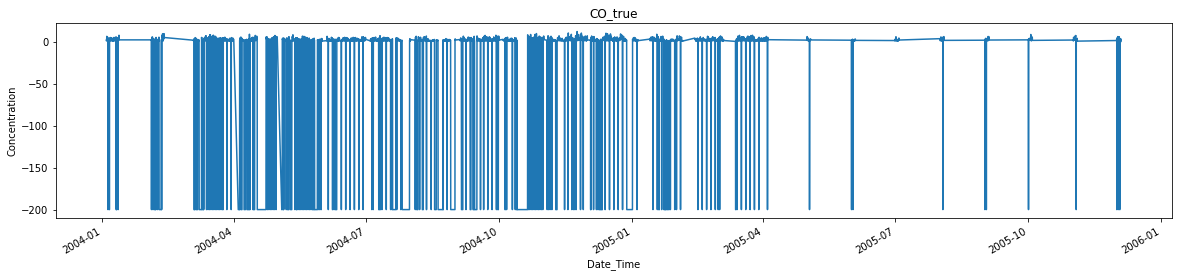

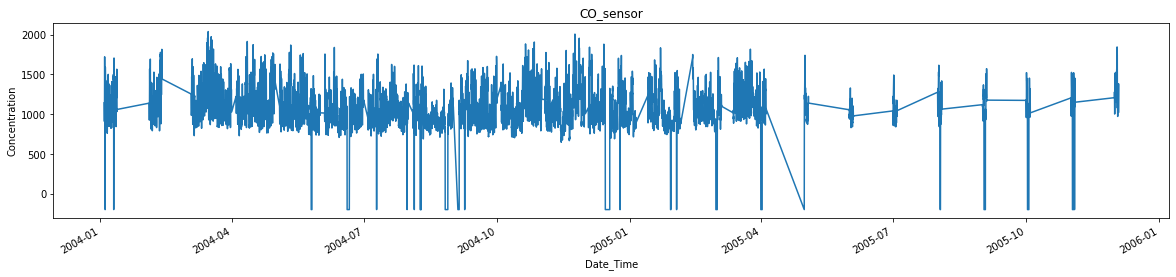

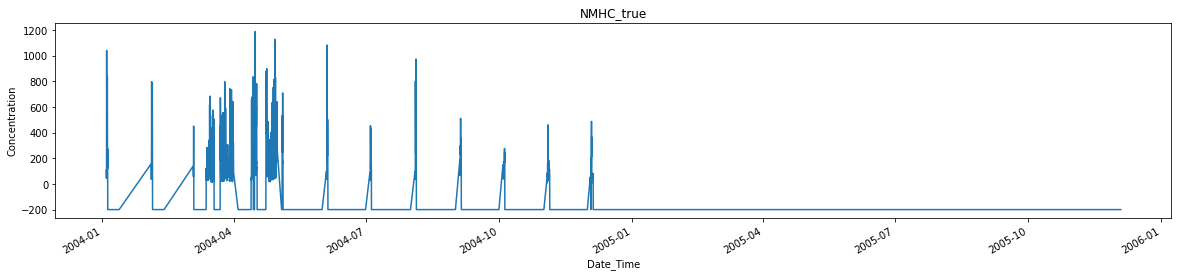

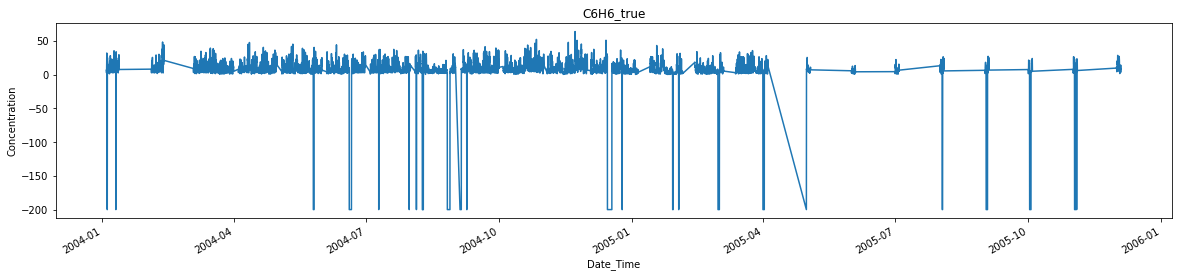

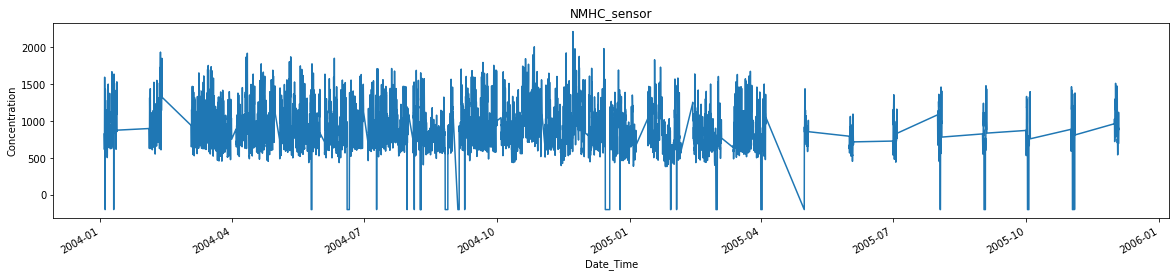

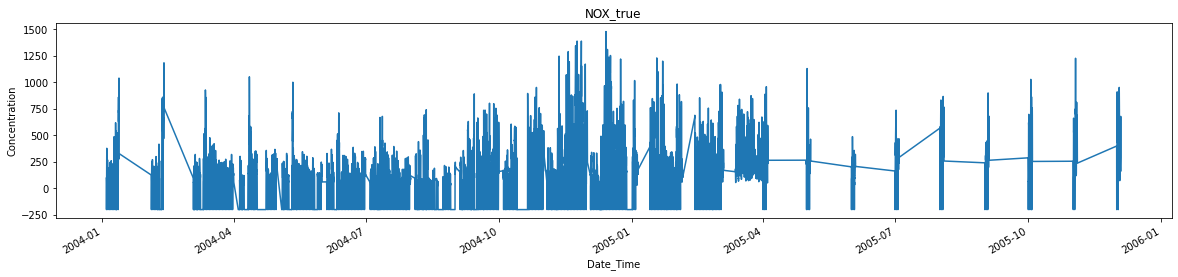

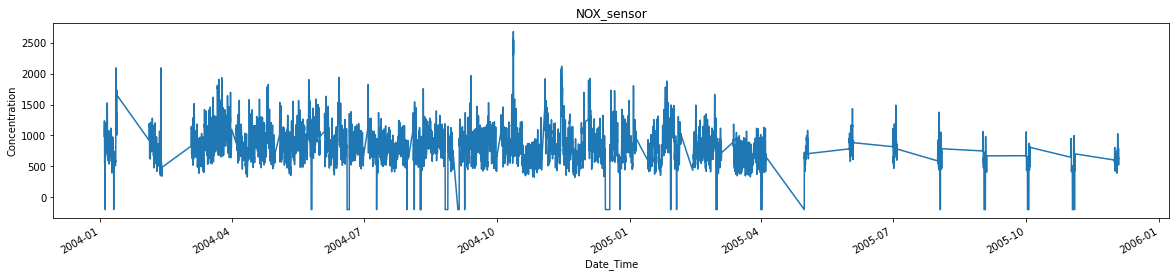

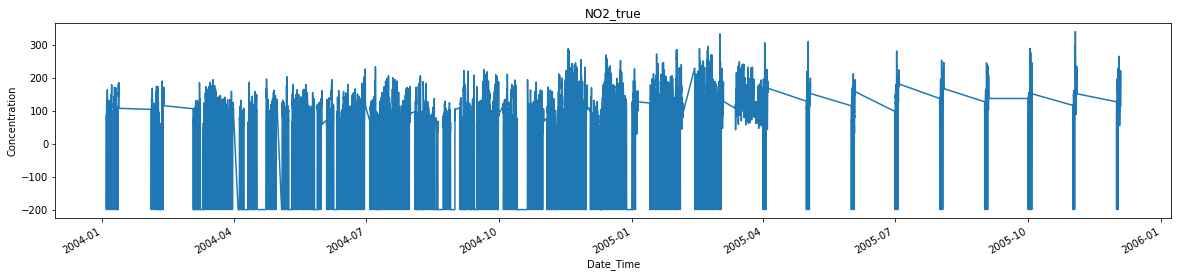

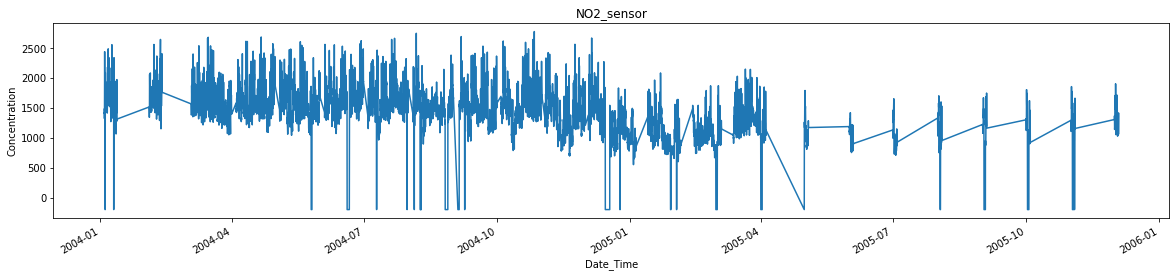

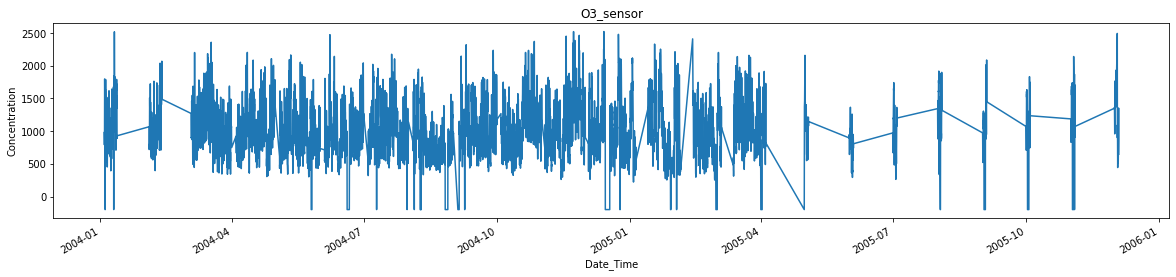

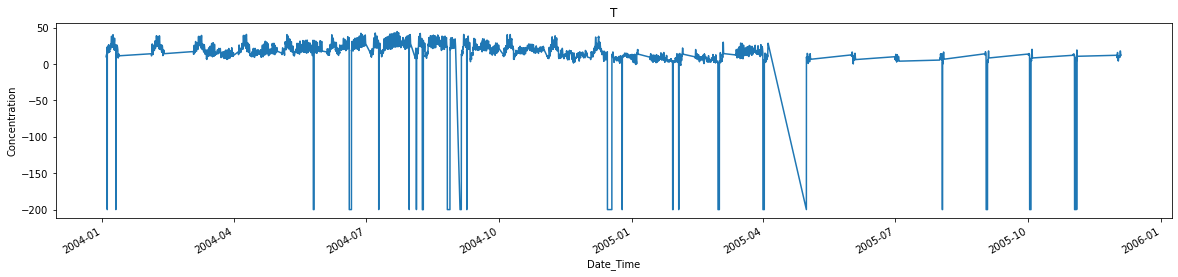

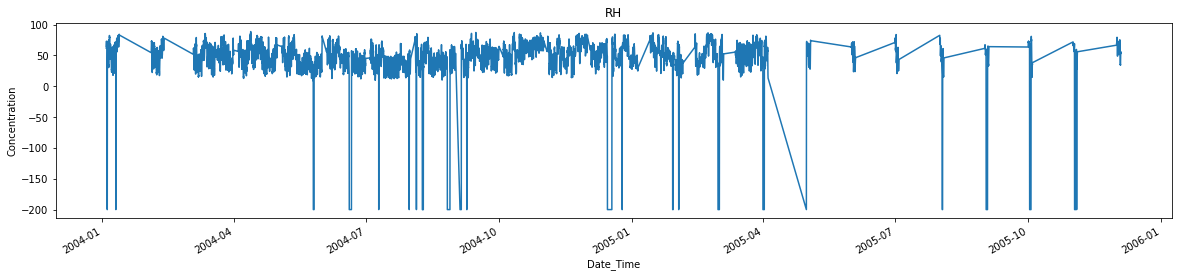

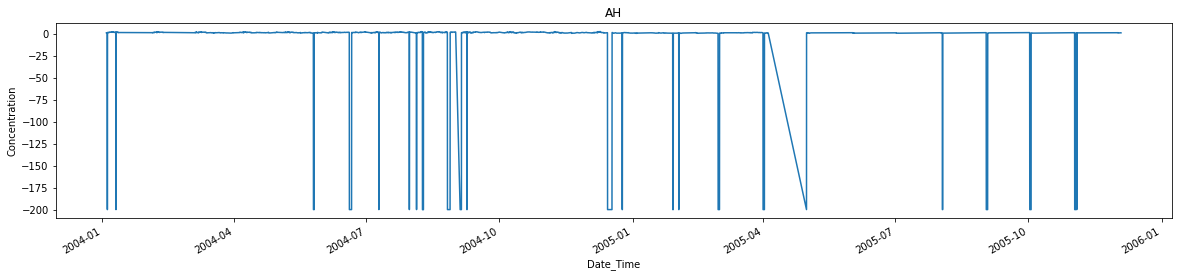

In [9]:
# plot the time series

for var in variables:
    
    data[var].plot(figsize=(20,4))
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

Looking at the plots we can argue the following:
    
- Data before March 2004 or after April 2005 seems to be more sparse (more data is missing)
- There are records missing: pandas plot interpolates linearly between available values.
- Some values are negative, most likely measurement errors, as concentrations should not be negative
- The sensors seem to be more reliable than the fixed stations, as they provide more and better quality data

For the demo, we will:

- Reduce the data to the span between March 2004 or after April 2005 (best quality)
- Work only with the sensor values
- Replace negative values with NA (that is, remove outliers)
- Impute missing data introduced above

## Reduce data span

In [10]:
# narrow down data to interval with most 
# data available, as per plots

data = data[(
    data['Date_Time'] >= '2004-04-01') &
    (data['Date_Time'] <= '2005-04-30')
]

# quick check: data span

data['Date_Time'].agg(['min', 'max'])

min   2004-04-04 00:00:00
max   2005-04-04 14:00:00
Name: Date_Time, dtype: datetime64[ns]

We see that the minimum and maximum values do not coincide with those we set, because there are timestamps missing. In other words, we do not have measurements for every single day or every single hour.

## Reduce number of variables

In [11]:
# remove measurements from fixed stations
# (we'll only work with sensors data)

drop_vars  = [var for var in data.columns if '_true' in var]

# remove relative humidity
drop_vars.append('AH')

# remove variables
data.drop(labels=drop_vars, axis=1, inplace=True)

data.shape

(7677, 8)

In [12]:
# check remaining variables

data.columns

Index(['Date_Time', 'CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor',
       'O3_sensor', 'T', 'RH'],
      dtype='object')

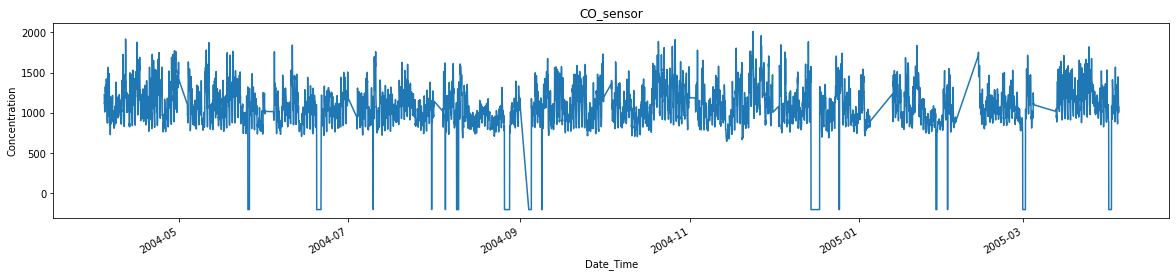

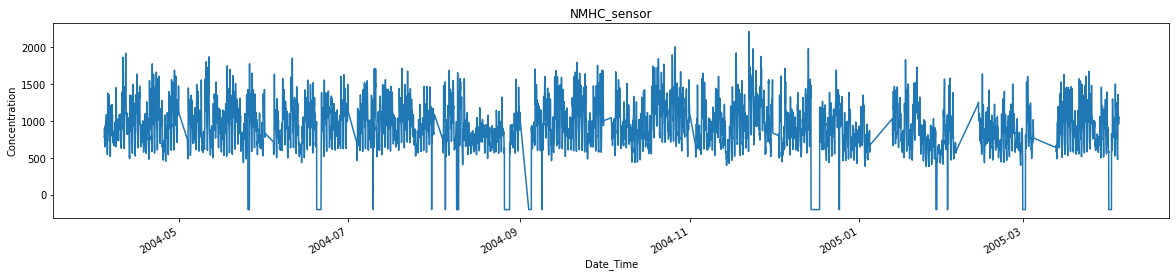

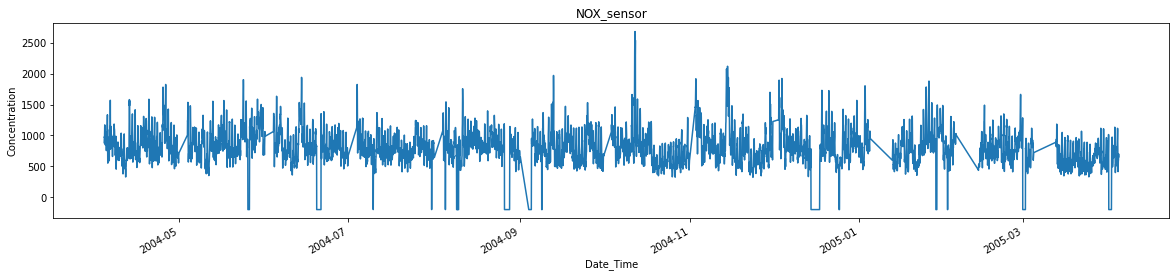

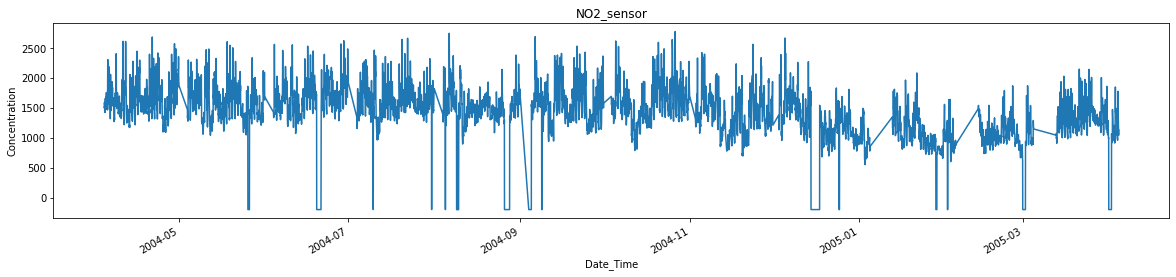

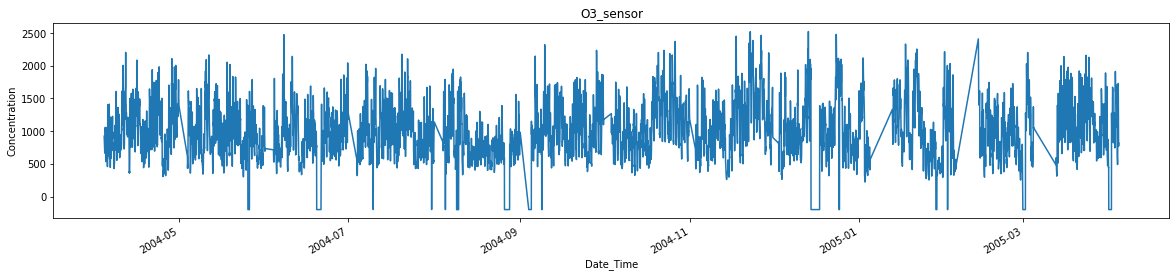

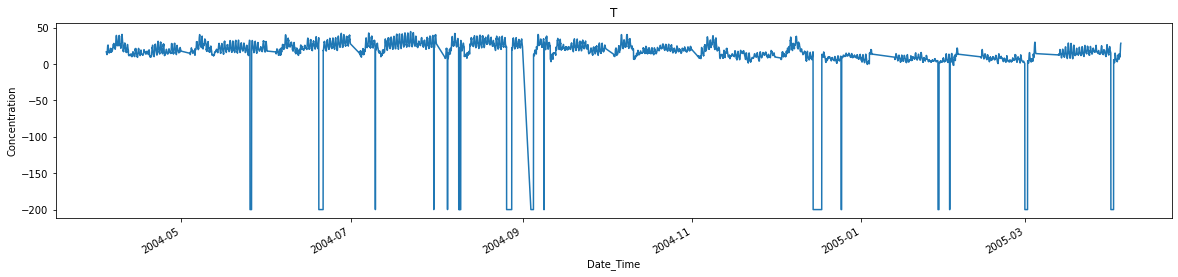

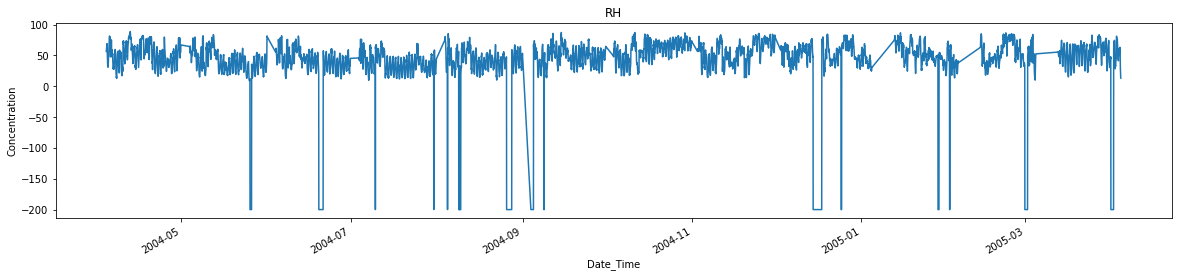

In [13]:
# capture the variables
variables = list(data.columns[1:])


# plot the time series again
for var in variables:
    
    data[var].plot(figsize=(20,4))
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

The data looks much better. 

We have entire days of records missing (note big gaps). These gaps occur across all sensors. This happens because all sensors are located within 1 measurement unit. So if for some reason the unit does not work, we will miss records for all sensors. 

I don't think that filling in entire days of missing data is the way forward, so we will not use those days to train the forecasting model.

Having said this, I would like to show you which time stamps are missing.

## Missing timestamps

In [14]:
# we determine the difference in time between
# one row and its previous row

data['diff'] = data['Date_Time'].diff()

# we expect the difference to be 1 hr if all records
# are present. If we miss some hourly records, the difference
# will be bigger:

data[data['diff'] > datetime.timedelta(hours=1)].head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,diff
Date_Time,,,,,,,,,
2004-05-04,2004-05-04,1102.0,750.0,1007.0,1470.0,613.0,14.7,64.4,3 days 01:00:00
2004-06-04,2004-06-04,1015.0,718.0,1065.0,1428.0,714.0,16.6,55.4,3 days 01:00:00
2004-07-04,2004-07-04,948.0,710.0,1127.0,1352.0,575.0,15.7,45.9,3 days 01:00:00
2004-08-04,2004-08-04,1020.0,752.0,1074.0,1398.0,839.0,9.3,75.0,3 days 01:00:00
2004-09-04,2004-09-04,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,3 days 01:00:00


In the above view of the data, we see some timestamps, for which, the previous hourly records are missing. That is why the difference is bigger than 1 hr. In fact, for the data shown, 3 entire days of recordings are missing.

Let's have a closer look at one of those timestamps as an example:

In [15]:
timestamp_ = '2004-05-05'

data[data['Date_Time']<= timestamp_].tail(30)

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,diff
Date_Time,,,,,,,,,
2004-04-30 19:00:00,2004-04-30 19:00:00,1626.0,1476.0,555.0,2356.0,1786.0,19.8,58.6,0 days 01:00:00
2004-04-30 20:00:00,2004-04-30 20:00:00,1449.0,1282.0,625.0,2100.0,1569.0,19.1,61.1,0 days 01:00:00
2004-04-30 21:00:00,2004-04-30 21:00:00,1363.0,1152.0,684.0,1951.0,1495.0,18.2,65.4,0 days 01:00:00
2004-04-30 22:00:00,2004-04-30 22:00:00,1371.0,1136.0,689.0,1927.0,1471.0,18.1,66.1,0 days 01:00:00
2004-04-30 23:00:00,2004-04-30 23:00:00,1406.0,1107.0,718.0,1872.0,1384.0,17.7,66.9,0 days 01:00:00
2004-05-04 00:00:00,2004-05-04 00:00:00,1102.0,750.0,1007.0,1470.0,613.0,14.7,64.4,3 days 01:00:00
2004-05-04 01:00:00,2004-05-04 01:00:00,969.0,611.0,1239.0,1330.0,430.0,14.8,63.3,0 days 01:00:00
2004-05-04 02:00:00,2004-05-04 02:00:00,983.0,600.0,1233.0,1375.0,485.0,15.0,61.5,0 days 01:00:00
2004-05-04 03:00:00,2004-05-04 03:00:00,876.0,505.0,1456.0,1294.0,467.0,15.5,56.9,0 days 01:00:00


If you try and search in the data for the timestamp in question, you'll see that the previous hourly records are missing. Shame!

In [16]:
# I'll drop the diff variable now

data.drop(labels=['diff'], axis=1, inplace=True)

## Data Analysis: Seasonality

Air pollutants change with car traffic. In rush hour we have more pollutants. During night hours we have less pollutants.

Let's see if what I am saying is true:

In [17]:
# capture time only in a time variable

data['Time'] = data['Date_Time'].dt.time

data['Time'].head()

Date_Time
2004-04-04 00:00:00    00:00:00
2004-04-04 01:00:00    01:00:00
2004-04-04 02:00:00    02:00:00
2004-04-04 03:00:00    03:00:00
2004-04-04 04:00:00    04:00:00
Name: Time, dtype: object

Text(0, 0.5, 'Concentration')

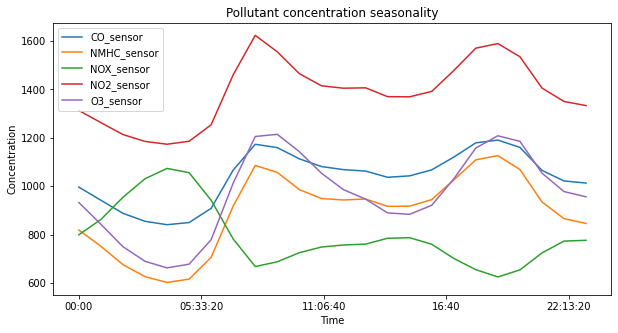

In [18]:
# plot average pollutant concentration per hr

data.groupby('Time')[variables[:-2]].mean().plot(figsize=(10,5))
plt.title('Pollutant concentration seasonality')
plt.ylabel('Concentration')

Bingo! We see more pollutants at around 8-9 am, and then again at 18-19 hs.

We also see that the concentration of the pollutants is correlated. So we could use the values of one pollutant to infer those of the others.

NOX cycle is different, with a peak at night.

In [19]:
# drop the time variable from the data

data.drop(labels=['Time'], axis=1, inplace=True)

# Video 2: Feature engineering

## Outliers

Now, we are going to go ahead and remove those negative values from our dataset

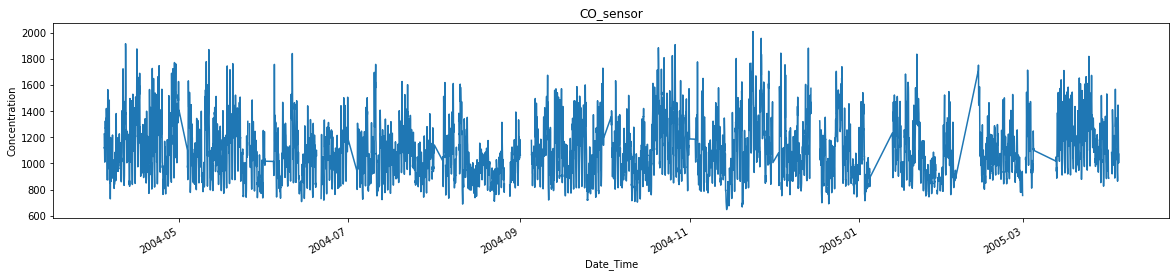

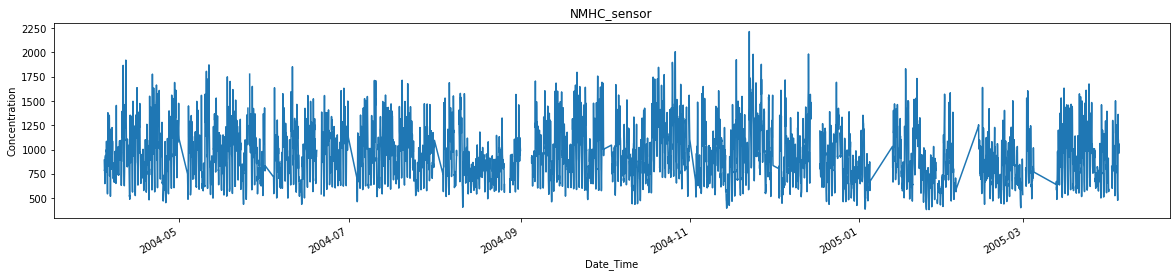

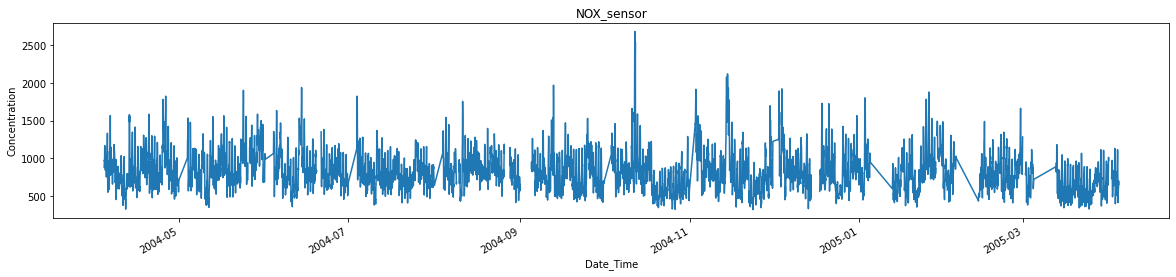

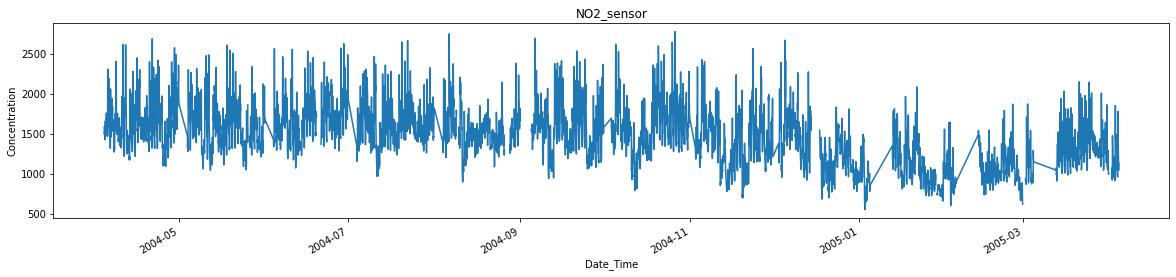

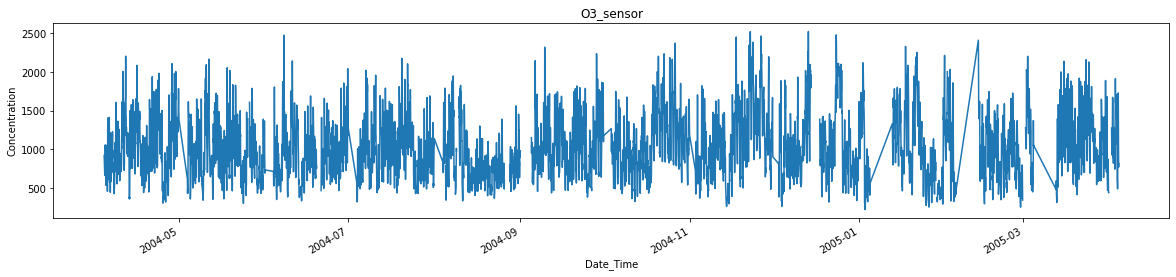

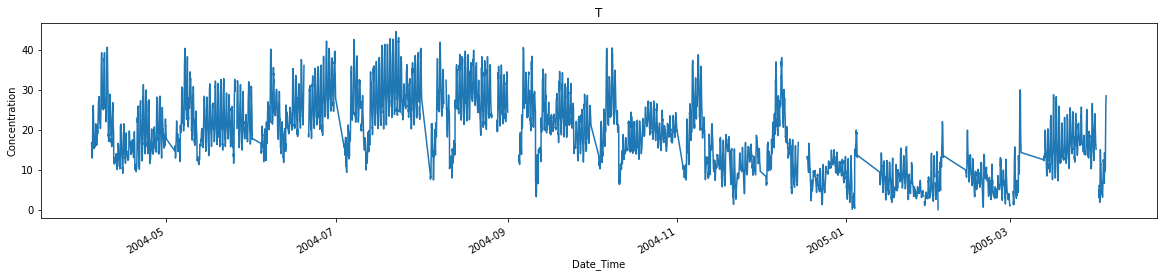

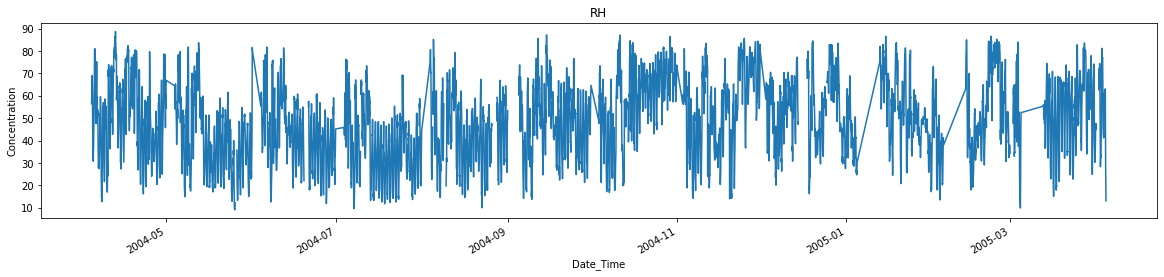

In [20]:
for var in variables:
    
    # if the value is negative, replace it by nan
    data[var] = np.where(data[var]<0, np.nan, data[var])
    
    # plot the time series
    data[var].plot(figsize=(20,4))
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

In [21]:
# now we have missing data

data.isnull().sum()

Date_Time        0
CO_sensor      284
NMHC_sensor    284
NOX_sensor     284
NO2_sensor     284
O3_sensor      284
T              297
RH             284
dtype: int64

In [22]:
# we can see that there are entire days of records missing, so 
# I think it is best not to impute this and to just remove
# them from the data

data[data['CO_sensor'].isnull()]

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,,
2004-05-25 19:00:00,2004-05-25 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 20:00:00,2004-05-25 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 21:00:00,2004-05-25 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 22:00:00,2004-05-25 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 23:00:00,2004-05-25 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2005-04-01 19:00:00,2005-04-01 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01 20:00:00,2005-04-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01 21:00:00,2005-04-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Imputation

We will just remove the observations with missing data

In [23]:
data.dropna(inplace=True)

data.isnull().sum()

Date_Time      0
CO_sensor      0
NMHC_sensor    0
NOX_sensor     0
NO2_sensor     0
O3_sensor      0
T              0
RH             0
dtype: int64

In [24]:
data.shape

(7380, 8)

## Forecasting

Now, we are ready to start creating some features for forecasting. 

We will begin with a simple scenario, we just want to forecast, pollutant in the next hour:

<img src='../forecasting_framework.png' width="600" height="600">


We want to predict pollutants at time t, and we know the concentration up to t-1. So for each t, we can use data up to t-1. 

Except for the timestamp, because we know at which time we want to predict pollutants.

Let's go and create some features

In [25]:
data.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,892.0,884.0,1580.0,923.0,16.7,56.5
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,843.0,929.0,1551.0,862.0,15.9,59.2
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,782.0,980.0,1500.0,752.0,15.2,62.4
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,793.0,965.0,1521.0,791.0,14.7,65.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,682.0,1090.0,1448.0,697.0,14.3,65.3


In [26]:
# our original time series
variables

['CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

In [27]:
# the variables we want to forecast

pollutants = variables[:-2]

pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

## Extract time related features

These are features with information we can derive straightaway from the timestamp.

In [28]:
# straightaway with pandas

data['Month'] = data['Date_Time'].dt.month
data['Week'] = data['Date_Time'].dt.isocalendar().week
data['Day'] = data['Date_Time'].dt.day
data['Day_of_week'] = data['Date_Time'].dt.day_of_week
data['Hour'] = data['Date_Time'].dt.hour

# with some tiny manipulation
data['is_weekend'] = np.where(data['Day_of_week'].isin(['5,6']),1,0)

# time vars
time_vars = ['Month', 'Week', 'Day', 'Day_of_week', 'Hour']
                               
data[['Date_Time']+time_vars].head()

,Date_Time,Month,Week,Day,Day_of_week,Hour
Date_Time,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,4,14,4,6,0
2004-04-04 01:00:00,2004-04-04 01:00:00,4,14,4,6,1
2004-04-04 02:00:00,2004-04-04 02:00:00,4,14,4,6,2
2004-04-04 03:00:00,2004-04-04 03:00:00,4,14,4,6,3
2004-04-04 04:00:00,2004-04-04 04:00:00,4,14,4,6,4


## Lag Features

That lag features are values in the past that we use to predict the future.

<img src='../lag_features.png' width="600" height="600">


I will use the following proxies to predict the next hr pollutant concentration

- the pollutant concentration the previous hr (t-1)
- the pollutant concentration the same hr the previous day (t-24)

The thinking behind is that pollutant concentration does not change very fast and also has a 24 hr seasonality as we saw previously.

**We need to be careful, because we do not have values for all timestamps. So we need to shift using pandas frequency to be safe**.

In [29]:
# see how we move the variables forward 1 hr

# so that now, the pollutant concentration from the previous
# hr is aligned with the current hr timestamp, that is
# t, the time stamp we want to make predictions about

# shift the data forward 1 HR
tmp = data[variables].shift(freq='1H')

# name the new variables
tmp.columns = [v + '_minus_1' for v in variables]


# add the variables to the original data
print('data size before')
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how='left')

print('data size after')
print(data.shape)

data[['Date_Time', 'CO_sensor', 'CO_sensor_minus_1']].head()

data size before
(7380, 14)
data size after
(7380, 21)


,Date_Time,CO_sensor,CO_sensor_minus_1
Date_Time,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,1224.0
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,1215.0
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,1115.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,1124.0


We see for example that 1224, is now moved forward to the next t.

In [30]:
# we have some missing data, for those rows where there
# is not data available in the previous hr

data.isnull().sum()

Date_Time               0
CO_sensor               0
NMHC_sensor             0
NOX_sensor              0
NO2_sensor              0
O3_sensor               0
T                       0
RH                      0
Month                   0
Week                    0
Day                     0
Day_of_week             0
Hour                    0
is_weekend              0
CO_sensor_minus_1      29
NMHC_sensor_minus_1    29
NOX_sensor_minus_1     29
NO2_sensor_minus_1     29
O3_sensor_minus_1      29
T_minus_1              29
RH_minus_1             29
dtype: int64

Our timestamps are not equidistant. This means that not every row has information in the previous hr.

But, as we specified the frequency in pandas shift(), for those records where we do not have a value in the previous hr, we will see NAN. Look below:

In [31]:
timestamp_

'2004-05-05'

In [32]:
data[data['Date_Time']<= timestamp_][['Date_Time', 'CO_sensor', 'CO_sensor_minus_1']].tail(30)

,Date_Time,CO_sensor,CO_sensor_minus_1
Date_Time,,,
2004-04-30 19:00:00,2004-04-30 19:00:00,1626.0,1480.0
2004-04-30 20:00:00,2004-04-30 20:00:00,1449.0,1626.0
2004-04-30 21:00:00,2004-04-30 21:00:00,1363.0,1449.0
2004-04-30 22:00:00,2004-04-30 22:00:00,1371.0,1363.0
2004-04-30 23:00:00,2004-04-30 23:00:00,1406.0,1371.0
2004-05-04 00:00:00,2004-05-04 00:00:00,1102.0,NaN
2004-05-04 01:00:00,2004-05-04 01:00:00,969.0,1102.0
2004-05-04 02:00:00,2004-05-04 02:00:00,983.0,969.0
2004-05-04 03:00:00,2004-05-04 03:00:00,876.0,983.0


In [33]:
# Now we repeat, but moving forward the values 24 hs

# move forward 24 hrs
tmp = data[variables].shift(freq='24H')


# rename the variables
tmp.columns = [v + '_minus_24' for v in variables]


# add the features to the original data
print('data size before')
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how='left')

print('data size after')
print(data.shape)

data[['Date_Time', 'CO_sensor', 'CO_sensor_minus_24']].head(25)

data size before
(7380, 21)
data size after
(7380, 28)


,Date_Time,CO_sensor,CO_sensor_minus_24
Date_Time,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,NaN
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,NaN
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,NaN
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,NaN
2004-04-04 05:00:00,2004-04-04 05:00:00,1010.0,NaN
2004-04-04 06:00:00,2004-04-04 06:00:00,1074.0,NaN
2004-04-04 07:00:00,2004-04-04 07:00:00,1034.0,NaN
2004-04-04 08:00:00,2004-04-04 08:00:00,1130.0,NaN


Note now that 1224, which is the value corresponding to April 4 at midnight, is not located in April 5th at midnight. For all previous values, we have NA, because there is no info about the features 24 hs before.

In [34]:
data.isnull().sum()

Date_Time                 0
CO_sensor                 0
NMHC_sensor               0
NOX_sensor                0
NO2_sensor                0
O3_sensor                 0
T                         0
RH                        0
Month                     0
Week                      0
Day                       0
Day_of_week               0
Hour                      0
is_weekend                0
CO_sensor_minus_1        29
NMHC_sensor_minus_1      29
NOX_sensor_minus_1       29
NO2_sensor_minus_1       29
O3_sensor_minus_1        29
T_minus_1                29
RH_minus_1               29
CO_sensor_minus_24      474
NMHC_sensor_minus_24    474
NOX_sensor_minus_24     474
NO2_sensor_minus_24     474
O3_sensor_minus_24      474
T_minus_24              474
RH_minus_24             474
dtype: int64

## Window features

Window features are averages of the features values over a pre-defined time window:

<img src='../window_features.png' width="600" height="600">

For the demo, I will take the average 3 previous values of the ts, to predict the current value. 

We first need to calculate the average of the 3 former values, and then, move that value forward:

In [35]:
# use the mean of the 3 previous hours as input variables

tmp = (data[variables]
       .rolling(window='3H').mean()  # average the last 3 hr values.
       .shift(freq='1H')  # Move the average 1 step forward
       )

# rename the columns
tmp.columns = [v + '_window' for v in variables]


# view of the result
tmp.head(10)

,CO_sensor_window,NMHC_sensor_window,NOX_sensor_window,NO2_sensor_window,O3_sensor_window,T_window,RH_window
Date_Time,,,,,,,
2004-04-04 01:00:00,1224.000000,892.000000,884.000000,1580.000000,923.000000,16.700000,56.500000
2004-04-04 02:00:00,1219.500000,867.500000,906.500000,1565.500000,892.500000,16.300000,57.850000
2004-04-04 03:00:00,1184.666667,839.000000,931.000000,1543.666667,845.666667,15.933333,59.366667
2004-04-04 04:00:00,1151.333333,806.000000,958.000000,1524.000000,801.666667,15.266667,62.200000
2004-04-04 05:00:00,1089.000000,752.333333,1011.666667,1489.666667,746.666667,14.733333,64.233333
2004-04-04 06:00:00,1054.000000,708.333333,1075.333333,1467.666667,717.333333,14.233333,65.600000
2004-04-04 07:00:00,1037.333333,687.666667,1093.666667,1456.666667,750.666667,13.633333,66.966667
2004-04-04 08:00:00,1039.333333,688.333333,1100.333333,1448.333333,789.333333,13.433333,66.800000
2004-04-04 09:00:00,1079.333333,711.666667,1064.333333,1457.333333,844.000000,13.966667,64.300000


In [36]:
# join the variables to the original data
print('data size before')
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how='left')

print('data size after')
print(data.shape)

data[['Date_Time', 'CO_sensor', 'CO_sensor_window']].head()

data size before
(7380, 28)
data size after
(7380, 35)


,Date_Time,CO_sensor,CO_sensor_window
Date_Time,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,1224.000000
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,1219.500000
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,1184.666667
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,1151.333333


Now we make some manual calculations to convince ourselves of the results.

In [37]:
(1215+1224)/2

1219.5

In [38]:
(1115+1215+1224)/3

1184.6666666666667

**Very important:** See how the average of the previous 3 hs was moved an hr forward to time t, the time we want to forecast.

## Feature combinations: total pollutants

We mentioned that we can also combine time series to create new features. So here we will add up all pollutants concentrations.

Not sure it makes sense, but indulge me for the demo.

**Very important:**

We only know the concentration of the pollutants up to 1 HR before the forecast time, t, so we should add the lagged features and not the original variables!

In [39]:
# capture all lagged features
lag_1 = [v for v in data.columns if 'minus_1' in v]

# remove temperature and humidity
lag_1 = lag_1[:-2]

lag_1

['CO_sensor_minus_1',
 'NMHC_sensor_minus_1',
 'NOX_sensor_minus_1',
 'NO2_sensor_minus_1',
 'O3_sensor_minus_1']

In [40]:
data['total_poll_m_1'] = data[lag_1].sum(axis=1)

data[lag_1 + ['total_poll_m_1']].head()

,CO_sensor_minus_1,NMHC_sensor_minus_1,NOX_sensor_minus_1,NO2_sensor_minus_1,O3_sensor_minus_1,total_poll_m_1
Date_Time,,,,,,
2004-04-04 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
2004-04-04 01:00:00,1224.0,892.0,884.0,1580.0,923.0,5503.0
2004-04-04 02:00:00,1215.0,843.0,929.0,1551.0,862.0,5400.0
2004-04-04 03:00:00,1115.0,782.0,980.0,1500.0,752.0,5129.0
2004-04-04 04:00:00,1124.0,793.0,965.0,1521.0,791.0,5194.0


In [41]:
# Now we repeat the exercise for the features with 24 Hr lag

# capture lagged features
lag_24 = [v for v in data.columns if 'minus_24' in v]

# remove temperature and humidity
lag_24 = lag_24[:-2]

data['total_poll_m_24'] = data[lag_24].sum(axis=1)

data[lag_24 + ['total_poll_m_24']].tail()

,CO_sensor_minus_24,NMHC_sensor_minus_24,NOX_sensor_minus_24,NO2_sensor_minus_24,O3_sensor_minus_24,total_poll_m_24
Date_Time,,,,,,
2005-04-04 10:00:00,1334.0,1174.0,524.0,1432.0,1643.0,6107.0
2005-04-04 11:00:00,1280.0,1165.0,533.0,1435.0,1605.0,6018.0
2005-04-04 12:00:00,1330.0,1145.0,537.0,1399.0,1668.0,6079.0
2005-04-04 13:00:00,1349.0,1193.0,507.0,1493.0,1710.0,6252.0
2005-04-04 14:00:00,1349.0,1167.0,515.0,1443.0,1632.0,6106.0


## Cyclical Features

Now, some features are cyclical in nature. For example hr and month, and days as well. In this sense, December (12) is closer to January (1) than to June (6). This relationship is not captured by the numerical representation of this features. But we could change it if we transformed this variables with the sine and cosine.

We will discuss this technique later on in the course. For now, let's create this features with a transformer from the Feature-engine library

[CyclicalTransformer](https://feature-engine.readthedocs.io/en/latest/creation/CyclicalTransformer.html)

In [42]:
data[['Month', 'Hour']].isnull().sum()

Month    0
Hour     0
dtype: int64

In [43]:
cyclical = CyclicalTransformer(
    variables=['Month', 'Hour'], #the features we want to transform
    drop_original=False, # whether to drop the original features
)

data = cyclical.fit_transform(data)

In [44]:
data.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,NO2_sensor_window,O3_sensor_window,T_window,RH_window,total_poll_m_1,total_poll_m_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,892.0,884.0,1580.0,923.0,16.7,56.5,4,14,...,NaN,NaN,NaN,NaN,0.0,0.0,0.866025,-0.5,0.000000,1.000000
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,843.0,929.0,1551.0,862.0,15.9,59.2,4,14,...,1580.000000,923.000000,16.700000,56.500000,5503.0,0.0,0.866025,-0.5,0.269797,0.962917
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,782.0,980.0,1500.0,752.0,15.2,62.4,4,14,...,1565.500000,892.500000,16.300000,57.850000,5400.0,0.0,0.866025,-0.5,0.519584,0.854419
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,793.0,965.0,1521.0,791.0,14.7,65.0,4,14,...,1543.666667,845.666667,15.933333,59.366667,5129.0,0.0,0.866025,-0.5,0.730836,0.682553
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,682.0,1090.0,1448.0,697.0,14.3,65.3,4,14,...,1524.000000,801.666667,15.266667,62.200000,5194.0,0.0,0.866025,-0.5,0.887885,0.460065


We can see the newly created features at the end of the dataframe.

## Drop Missing data

When creating lag and window features, we introduced some missing data. 

In [45]:
# % of missing data

data.isnull().sum()/len(data)

Date_Time               0.000000
CO_sensor               0.000000
NMHC_sensor             0.000000
NOX_sensor              0.000000
NO2_sensor              0.000000
O3_sensor               0.000000
T                       0.000000
RH                      0.000000
Month                   0.000000
Week                    0.000000
Day                     0.000000
Day_of_week             0.000000
Hour                    0.000000
is_weekend              0.000000
CO_sensor_minus_1       0.003930
NMHC_sensor_minus_1     0.003930
NOX_sensor_minus_1      0.003930
NO2_sensor_minus_1      0.003930
O3_sensor_minus_1       0.003930
T_minus_1               0.003930
RH_minus_1              0.003930
CO_sensor_minus_24      0.064228
NMHC_sensor_minus_24    0.064228
NOX_sensor_minus_24     0.064228
NO2_sensor_minus_24     0.064228
O3_sensor_minus_24      0.064228
T_minus_24              0.064228
RH_minus_24             0.064228
CO_sensor_window        0.003930
NMHC_sensor_window      0.003930
NOX_sensor

It is not a lot, so I will just remove those observations.

In [46]:
print('data size before')
print(data.shape)

data.dropna(inplace=True)

print('data size after')
print(data.shape)

data size before
(7380, 41)
data size after
(6894, 41)


# Video 3: train model with cross-val

In this part of the notebook, we will train Random Forest Regressors to predict the concentration of each pollutant in the next Hr.

But before that, I want to add some additional features. 

We saw that the pollutant concentration has intra day seasonality. So I want to add that information to the dataset. But, I should only use information learned from the data before the forecasting time. 

Doing this manually with pandas is a complicated. So I will instead create a transformer class with fit and transform functionality, just like any other Scikit-learn transformer, and then use it as part of a pipeline.

Let's go!


## Seasonality Features

We know that the pollutants have an intra day seasonality. And we want to capture this, using only data in the past, at the time of prediction. So we need to create a transformer class that we can use with Scikit-learn's cross validation.

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

# the base estimator adds the get and set parameters 
# functionality from sklearn

# the transformer mixin adds the fit_transform functionality

class SeasonalTransformer(BaseEstimator, TransformerMixin):
    
    
        def __init__(self, season_var, variables):
            
            # the user needs to pass the seasonal variable 
            # and the varibles that should be aggregated
            
            self.season_var = season_var
            self.variables=variables
            
        def fit(self, X, y=None):
            
            # we want to estimate the mean value of the 
            # variables in the seasonal term
            
            # here, mean pollutant concentration per hr
            
            # we make a copy not to over-write the user's data
            X = X.copy()
            
            # calcualte mean pollutant per hr
            self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()
            
            # rename the new variables
            self.seasonal_.columns = [v + '_season' for v in self.variables]
            
            return self
        
        def transform(self, X):
            
            # we want to add the seasonal component to the 
            # data to transform
            
            X = X.copy()
            
            X = X.merge(self.seasonal_, on=self.season_var, how='left')
            
            return X

In [48]:
# test the class

# we initialise the class as we would do with
# any sklearn transformer

# we pass the variable to use in the grouping,
# and the ones we want to group
seasonal_t = SeasonalTransformer(season_var='Hour', variables=pollutants)

# with fit, the transformer learns the groupings
seasonal_t.fit(data)

SeasonalTransformer(season_var='Hour',
                    variables=['CO_sensor', 'NMHC_sensor', 'NOX_sensor',
                               'NO2_sensor', 'O3_sensor'])

In [49]:
# it stores the seasonal values in its attribute

seasonal_t.seasonal_.head()

,CO_sensor_season,NMHC_sensor_season,NOX_sensor_season,NO2_sensor_season,O3_sensor_season
Hour,,,,,
0,1046.262411,867.762411,840.716312,1385.095745,982.609929
1,985.395105,791.884615,904.360140,1323.562937,886.643357
2,926.783217,711.363636,994.255245,1272.265734,789.213287
3,888.892361,655.559028,1070.447917,1235.996528,721.458333
4,871.860627,629.745645,1106.108014,1223.090592,693.836237


In [50]:
# now we add the variables to our data     

tmp = seasonal_t.transform(data)

tmp.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,total_poll_m_24,Month_sin,Month_cos,Hour_sin,Hour_cos,CO_sensor_season,NMHC_sensor_season,NOX_sensor_season,NO2_sensor_season,O3_sensor_season
0,2004-04-05 00:00:00,1065.0,789.0,936.0,1620.0,929.0,18.4,65.8,4,15,...,5503.0,0.866025,-0.5,0.000000,1.000000,1046.262411,867.762411,840.716312,1385.095745,982.609929
1,2004-04-05 01:00:00,999.0,692.0,1038.0,1588.0,778.0,16.4,79.2,4,15,...,5400.0,0.866025,-0.5,0.269797,0.962917,985.395105,791.884615,904.360140,1323.562937,886.643357
2,2004-04-05 02:00:00,911.0,599.0,1189.0,1517.0,633.0,16.1,80.0,4,15,...,5129.0,0.866025,-0.5,0.519584,0.854419,926.783217,711.363636,994.255245,1272.265734,789.213287
3,2004-04-05 03:00:00,873.0,545.0,1308.0,1471.0,497.0,15.6,81.0,4,15,...,5194.0,0.866025,-0.5,0.730836,0.682553,888.892361,655.559028,1070.447917,1235.996528,721.458333
4,2004-04-05 04:00:00,881.0,546.0,1335.0,1465.0,458.0,15.6,81.0,4,15,...,4945.0,0.866025,-0.5,0.887885,0.460065,871.860627,629.745645,1106.108014,1223.090592,693.836237


In this test, we learned the parameters from the same data we used to transform. In the coming sections, we will fit over a train set, and then transform both train and test sets.

## Separate into train and test

Now we begin to set up ourselves for training the forecasting model.

We will train the model on a certain portion of the data, and leave a bit out to evaluate the model.

Because these are time series, I prefer not to do a random split, but to split based on time:

In [51]:
data.index.min(), data.index.max()

(Timestamp('2004-04-05 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [52]:
# keep the last month to test

X_train = data[data.index<='2005-03-04']
X_test = data[data.index>'2005-03-04']

X_train.shape, X_test.shape

((6400, 41), (494, 41))

## Recap on variables

Let's recap on what we have in our data

In [53]:
# these are the pollutants original values
# the raw time series

pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

In [54]:
# these are the pollutants plus temperature and humidity
# all raw time series, the original data

variables

['CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

In [55]:
# now I capture the input variables, that is
# the features we crated to predict pollutant concentration
# at time t

input_variables = [v for v in data.columns if v not in variables]

input_variables.remove('Date_Time')

input_variables

['Month',
 'Week',
 'Day',
 'Day_of_week',
 'Hour',
 'is_weekend',
 'CO_sensor_minus_1',
 'NMHC_sensor_minus_1',
 'NOX_sensor_minus_1',
 'NO2_sensor_minus_1',
 'O3_sensor_minus_1',
 'T_minus_1',
 'RH_minus_1',
 'CO_sensor_minus_24',
 'NMHC_sensor_minus_24',
 'NOX_sensor_minus_24',
 'NO2_sensor_minus_24',
 'O3_sensor_minus_24',
 'T_minus_24',
 'RH_minus_24',
 'CO_sensor_window',
 'NMHC_sensor_window',
 'NOX_sensor_window',
 'NO2_sensor_window',
 'O3_sensor_window',
 'T_window',
 'RH_window',
 'total_poll_m_1',
 'total_poll_m_24',
 'Month_sin',
 'Month_cos',
 'Hour_sin',
 'Hour_cos']

In [56]:
# and these are the variables that should not be
# in the training set

vars_to_drop = [v for v in data.columns if v not in input_variables]

vars_to_drop

['Date_Time',
 'CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

## Train model with cross-validation

We want to train the forecasting model with cross-validation. But we do not want to do random cross-validation, instead we want to generate different portions of data based on time.

We are going to use the expanding window concept for this problem (more in coming videos)

We will use the TimeSeriesSplit from sklearn

[TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#using-cross-validation-iterators-to-split-train-and-test)

In [57]:
# we set it up to do expanding windows and 3 fold 
# cross-validation

tscv = TimeSeriesSplit(n_splits=3)

In [58]:
# set the feature engineering pipeline
# plus random forest regressor

# we want to add the seasonal features with cross-validation
# so we need to set it up inside a pipeline

pipe = Pipeline([
    
    # create seasonal features
    ('seasonal', SeasonalTransformer(
        season_var='Hour', variables=pollutants)
    ),
    
    # drop raw variables - only needed for seasonality
    ('drop_vars', DropFeatures(features_to_drop=vars_to_drop)),
    
    # random forests
    ('rf', RandomForestRegressor(
        n_estimators=50,
        max_depth=3,
        random_state=0,
    )),
    
])

In [59]:
# let's predict CO concentration
# to start and get familiar with the outputs

cv_results = cross_validate(
    estimator=pipe,         # our pipeline
    X=X_train,              # the training data
    y=X_train['CO_sensor'],  # the target
    cv=tscv,    # the cross validation scheme
    scoring='neg_root_mean_squared_error', # the metric to evaluate
    return_train_score=True, 
    return_estimator=True, # we want a final model to be trained on the entire train set
)

In [60]:
cv_results

{'fit_time': array([0.43130708, 0.75555301, 1.10378695]),
 'score_time': array([0.01402664, 0.01901364, 0.01302385]),
 'estimator': [Pipeline(steps=[('seasonal',
                   SeasonalTransformer(season_var='Hour',
                                       variables=['CO_sensor', 'NMHC_sensor',
                                                  'NOX_sensor', 'NO2_sensor',
                                                  'O3_sensor'])),
                  ('drop_vars',
                   DropFeatures(features_to_drop=['Date_Time', 'CO_sensor',
                                                  'NMHC_sensor', 'NOX_sensor',
                                                  'NO2_sensor', 'O3_sensor', 'T',
                                                  'RH'])),
                  ('rf',
                   RandomForestRegressor(max_depth=3, n_estimators=50,
                                         random_state=0))]),
  Pipeline(steps=[('seasonal',
                   SeasonalTransformer(sea

Text(0, 0.5, 'Importance')

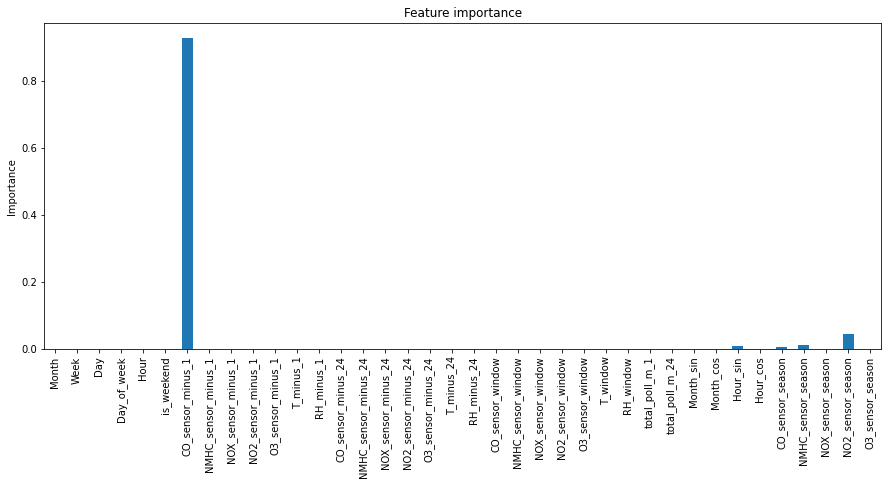

In [61]:
# let's now plot the feature importance

# the importance is stored in the estimator
tmp = pd.Series(cv_results['estimator']
                [0].named_steps['rf'].feature_importances_)

# let's add the variable names
tmp.index = input_variables + ['CO_sensor_season',
 'NMHC_sensor_season',
 'NOX_sensor_season',
 'NO2_sensor_season',
 'O3_sensor_season']

# and make a bar plot
tmp.plot.bar(figsize=(15,6))
plt.title('Feature importance')
plt.ylabel('Importance')

We see that the most important feature is the concentration of CO in the previous hr. The seasonal component of CO, NO2 and NMHC add a bit to the prediction.

So, most of the features we created are not really useful. And we could have probably made our lives easier by starting simpler, with just lags from the feature we want to predict. But then the demo would be really boring, wouldn't it? 

In [62]:
# now let's make predictions over the test set
preds = cv_results['estimator'][0].predict(X_test)

# and determine the rmse
mean_squared_error(X_test['CO_sensor'], preds, squared=False)

102.88062933604054

And we now plot the predictions against the truth.

<AxesSubplot:xlabel='Date_Time'>

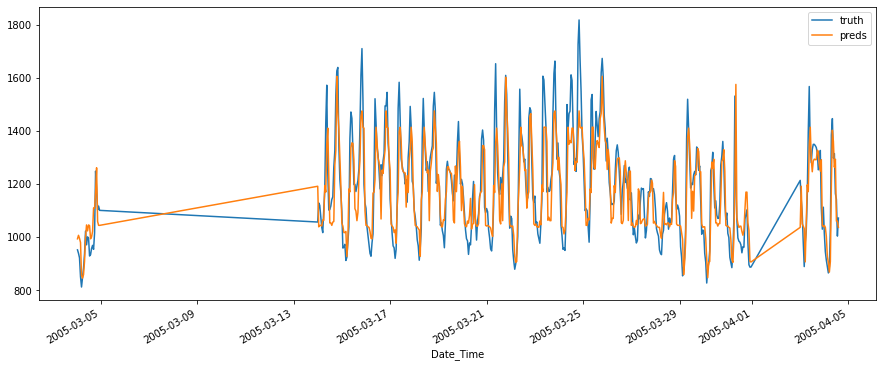

In [63]:
tmp = pd.concat([
    X_test['CO_sensor'].reset_index(drop=True),
    pd.Series(preds),
    ], axis=1)

tmp.columns = ['truth', 'preds']

tmp.index = X_test.index

tmp.plot(figsize=(15,6))

Our model seems to be making a fairly good job. Well done us! :p

## Multi-series predictions

Now, to make it a tiny bit more real, we will train models for every pollutant.

In [64]:
from sklearn.base import clone
# this is to clone the pipeline and 
# not retrain it every time

In [65]:
pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

In [66]:
# we will stored the trained pipelines in a 
# dictionary
models = {}


for pollutant in pollutants:

    # clone the pipeline
    pipe_int = clone(pipe)

    # train the model with cross-val
    cv_results = cross_validate(
        estimator=pipe_int,
        X=X_train,
        y=X_train[pollutant],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        return_train_score=True,
        return_estimator=True,
    )

    # store the results
    models[pollutant] = cv_results

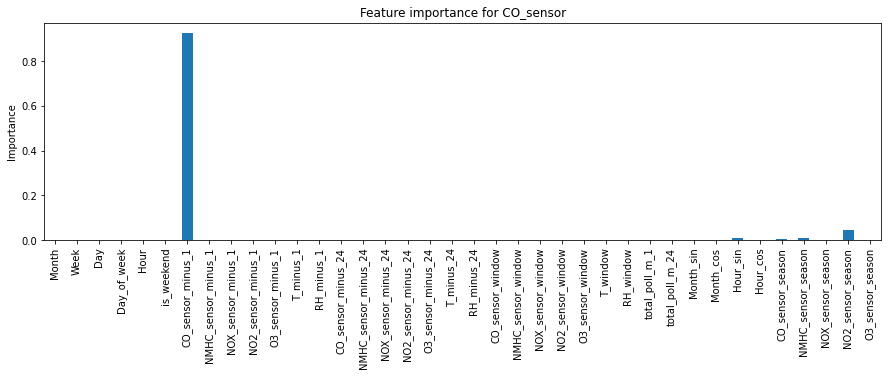

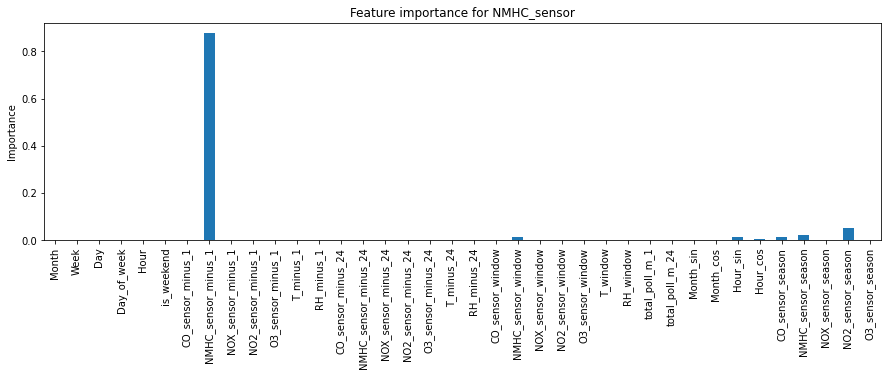

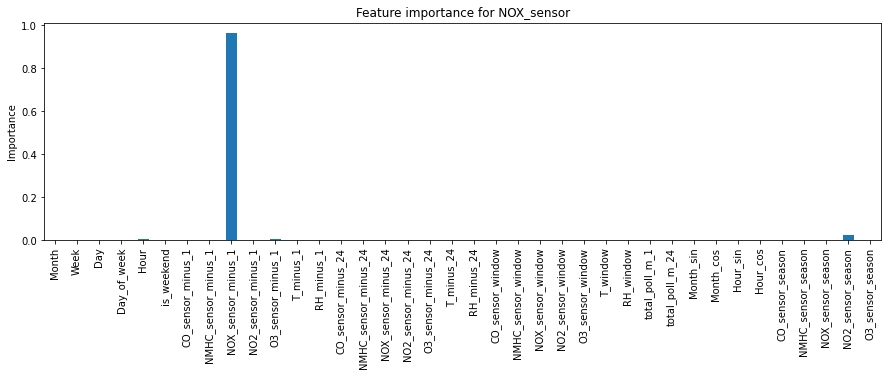

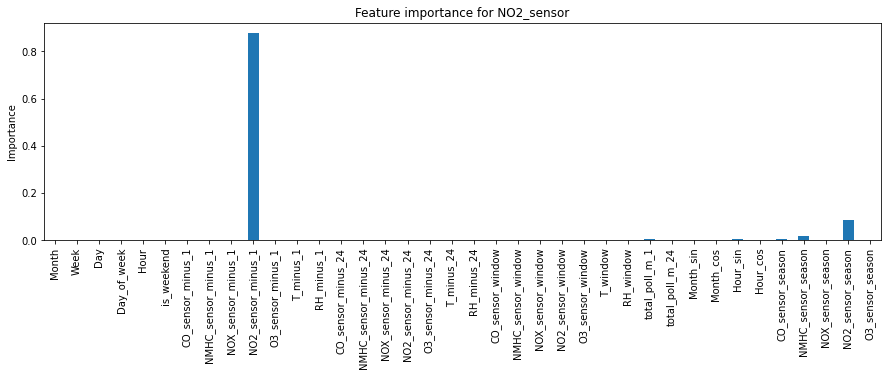

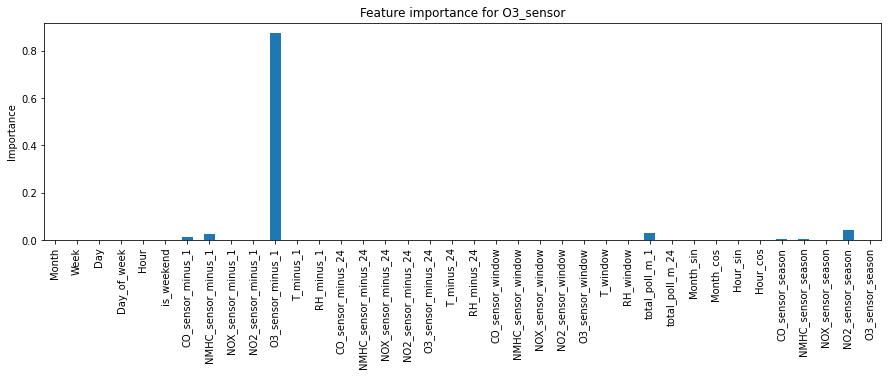

In [67]:
# now for every model we plot the 
# feature importance
for pollutant in pollutants:
    
    cv_results = models[pollutant]

    tmp = pd.Series(cv_results['estimator']
                    [0].named_steps['rf'].feature_importances_)

    tmp.index = input_variables + ['CO_sensor_season',
     'NMHC_sensor_season',
     'NOX_sensor_season',
     'NO2_sensor_season',
     'O3_sensor_season']

    tmp.plot.bar(figsize=(15,4))
    plt.title('Feature importance for ' + pollutant)
    plt.ylabel('Importance')
    plt.show()

CO_sensor
RMSE: 102.88062933604054


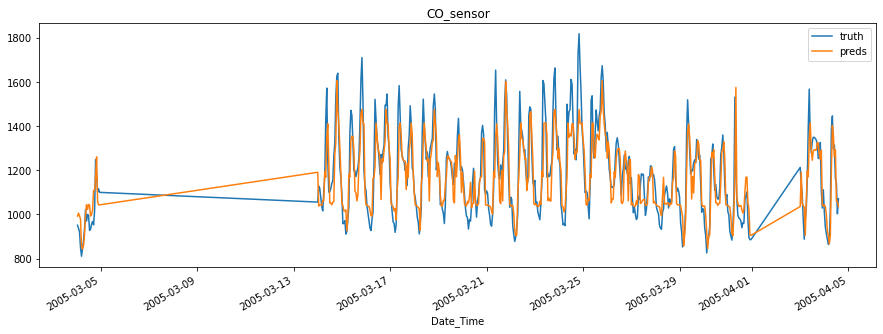

NMHC_sensor
RMSE: 121.1108741114408


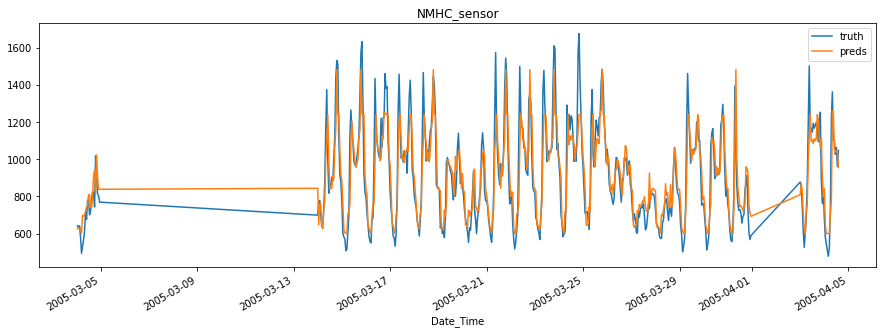

NOX_sensor
RMSE: 91.93402395361085


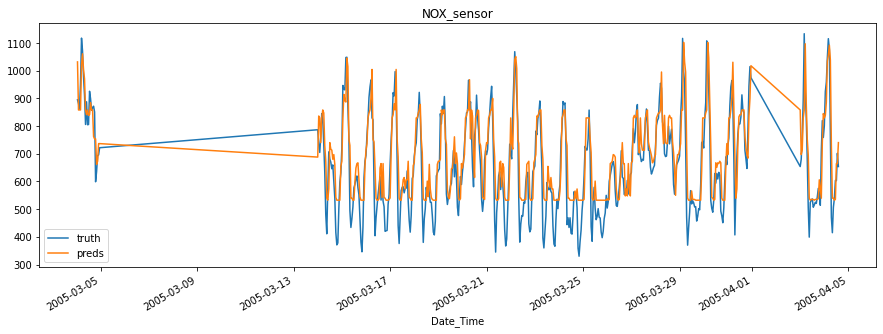

NO2_sensor
RMSE: 151.90799590928864


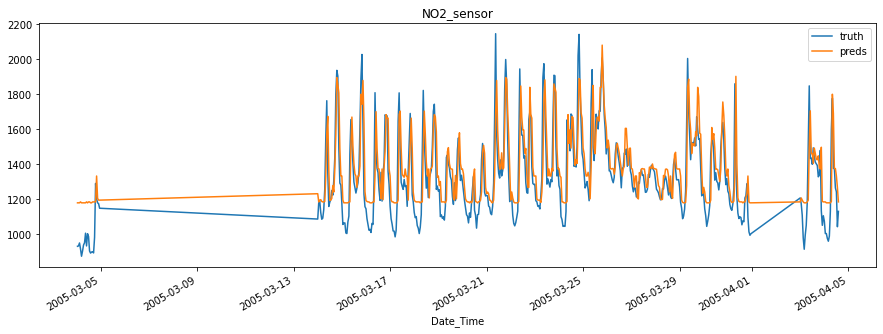

O3_sensor
RMSE: 193.30112291039543


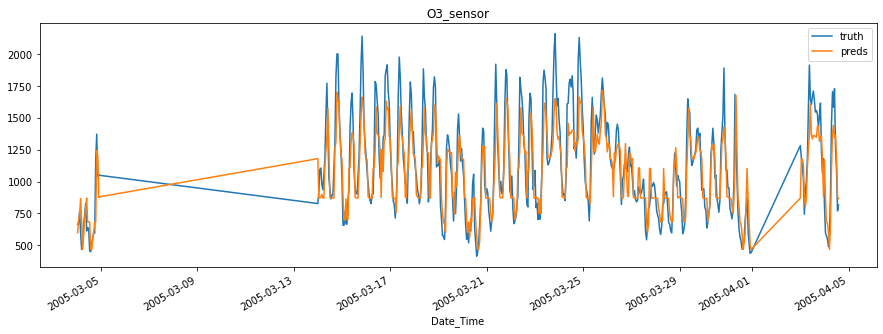

In [68]:
# and to finish off, we will test the model on the
# test set

for pollutant in pollutants:
    
    cv_results = models[pollutant]
    
    # make predictions
    preds = cv_results['estimator'][0].predict(X_test)

    # determine rmse
    rmse = mean_squared_error(X_test[pollutant], preds, squared=False)
    
    print(pollutant)
    print('RMSE:', rmse )

    # plot the predictions
    tmp = pd.concat([
        X_test[pollutant].reset_index(drop=True),
        pd.Series(preds),
        ], axis=1)

    tmp.columns = ['truth', 'preds']

    tmp.index = X_test.index

    tmp.plot(figsize=(15,5))
    plt.title(pollutant)
    plt.show()

In general the models look OK. They tend to be more conservative, not predicting the lowest or highest pollutant concentrations with good accuracy.

This is just a demo to get you started with feature engineering though.

That is all for this notebook, I hope you enjoyed it!